In [1]:
from tensorflow import keras
import tensorflow as tf
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn import model_selection

2022-12-06 18:16:38.351820: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-06 18:16:38.351840: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
path = Path("../datasets/Images_Transformed_565_160_120")
with open(path/'data.npy', 'rb') as d, open(path/"labels.npy", "rb") as l, open(path/"classes.npy", "rb") as c:
    data = np.load(d)
    labels = np.load(l)
    classes = np.load(c)
le = LabelEncoder()
le.classes_ = classes

In [3]:
print(labels.shape)
print(data.shape)
print(classes)

(105,)
(105, 120, 160, 3)
['Maria' 'Nikhil' 'Simon']


In [4]:
from collections import Counter
print(Counter(labels))

Counter({2: 49, 0: 45, 1: 11})


In [5]:
# Helper functions
def _565_channels_normalize(data: np.ndarray) -> np.ndarray:
    width, height, chan = data.shape
    channels = np.zeros(shape=(width, height, chan), dtype=np.float16)

    for x in range(width):
        for y in range(height):
            channels[x, y, 0] = data[x, y, 0] / 32
            channels[x, y, 1] = data[x, y, 1] / 64
            channels[x, y, 2] = data[x, y, 2] / 32

    return channels

# If we want to reverse the normalization -> 888
def normalized_to_888(data: np.ndarray) -> np.ndarray:
    width, height, chan = data.shape
    channels = np.zeros(shape=(width, height, chan), dtype=np.uint16)

    for x in range(width):
        for y in range(height):
            channels[x, y, 0] = data[x, y, 0] * 255
            channels[x, y, 1] = data[x, y, 1] * 255
            channels[x, y, 2] = data[x, y, 2] * 255

    return channels

In [6]:
# Normalize 565 channels
unscaled_data = data

data = []
for img in unscaled_data:
    data.append(_565_channels_normalize(img))
data = np.array(data)


In [7]:
train_data, validation_data, train_labels, validation_labels = model_selection.train_test_split(data,labels, random_state=50,test_size=0.3)
validation_data, test_data, validation_labels, test_labels = model_selection.train_test_split(validation_data,validation_labels, random_state=50,test_size=0.3)

print('train data shape:',np.shape(train_data))
print('validation data shape:',np.shape(validation_data))
print('train labels shape:',np.shape(train_labels))
print('validation labels shape:',np.shape(validation_labels))
print('test labels shape:',np.shape(test_data))
print('test labels shape:',np.shape(test_labels))

train data shape: (73, 120, 160, 3)
validation data shape: (22, 120, 160, 3)
train labels shape: (73,)
validation labels shape: (22,)
test labels shape: (10, 120, 160, 3)
test labels shape: (10,)


In [8]:
mean = np.mean(train_data, axis = 0)
std = np.std(train_data, axis = 0)

#train_data = (train_data-mean) / std
#validation_data = (validation_data-mean) / std

print(train_data)

[[[[0.9375 0.9375 0.9375]
   [0.9375 0.9375 0.9375]
   [0.875  0.8906 0.9062]
   ...
   [0.5625 0.4375 0.375 ]
   [0.5312 0.4375 0.375 ]
   [0.5625 0.4844 0.3438]]

  [[0.9375 0.9375 0.9375]
   [0.9375 0.9375 0.9375]
   [0.875  0.875  0.9062]
   ...
   [0.5625 0.4219 0.2812]
   [0.5312 0.4219 0.3125]
   [0.5625 0.4688 0.3125]]

  [[0.9375 0.9375 0.9375]
   [0.9375 0.9375 0.9375]
   [0.875  0.8906 0.9062]
   ...
   [0.5625 0.4531 0.3438]
   [0.5312 0.4219 0.3125]
   [0.5625 0.4844 0.3125]]

  ...

  [[0.5625 0.9375 0.9375]
   [0.5625 0.9375 0.9375]
   [0.5312 0.922  0.9375]
   ...
   [0.5312 0.4375 0.2812]
   [0.7188 0.6562 0.5   ]
   [0.7812 0.703  0.5312]]

  [[0.5625 0.9375 0.9375]
   [0.5625 0.9375 0.9375]
   [0.5312 0.922  0.9375]
   ...
   [0.5312 0.4375 0.2812]
   [0.7188 0.6406 0.5   ]
   [0.7812 0.7188 0.5312]]

  [[0.5625 0.9375 0.9375]
   [0.5625 0.9375 0.9375]
   [0.5312 0.922  0.9375]
   ...
   [0.5    0.4375 0.2812]
   [0.7188 0.6562 0.5   ]
   [0.8125 0.703  0.5312]]]


 

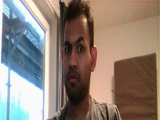

In [9]:
keras.utils.array_to_img(train_data[0])

In [10]:
classes_txt = classes
classes = len(le.classes_)
classes

3

In [11]:
import gc
gc.collect() # used to clear gpu memory (in theory lol)

32

In [12]:
# This model is too complicated, see further down for the model which is in progress

model = keras.models.Sequential([
    keras.layers.Input(shape=train_data.shape[1:]),
    #keras.layers.MaxPool2D((2,2), input_shape=train_data.shape[1:]),
    keras.layers.Conv2D(8, (3,3), activation="relu"),
    keras.layers.MaxPool2D((2,2)),
    keras.layers.Dropout(0.5),
    keras.layers.Conv2D(16, (3,3), activation="relu"),
    keras.layers.MaxPool2D((2,2)),
    keras.layers.Conv2D(32, (3,3), activation="relu"),
    keras.layers.MaxPool2D((2,2)),
    keras.layers.Conv2D(64, (3,3), activation="relu"),
    keras.layers.MaxPool2D((2,2)),
    #keras.layers.Conv2D(128, (3,3), activation="relu"),
    #keras.layers.MaxPool2D((2,2)),
    #keras.layers.Conv2D(256, (3,3), activation="relu"),
    #keras.layers.MaxPool2D((2,2)),
    keras.layers.Dropout(0.5),
    keras.layers.Flatten(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(70, activation="relu"),
    keras.layers.Dense(classes, activation="softmax")
    ])

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
#model.summary()



2022-12-06 18:16:51.591560: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-06 18:16:51.591587: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-06 18:16:51.591608: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Z3NB00K): /proc/driver/nvidia/version does not exist
2022-12-06 18:16:51.591882: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
#callback = keras.callbacks.EarlyStopping(monitor="loss", verbose=1, patience=10, min_delta=0.0001, mode="auto")
history = model.fit(train_data, train_labels, validation_data=(validation_data, validation_labels), batch_size=32, epochs=50)#, callbacks=[callback])

Epoch 1/50
3/3 [==============================] - 1s 127ms/step - loss: 1.0175 - accuracy: 0.4795 - val_loss: 0.9198 - val_accuracy: 0.5000
Epoch 2/50
3/3 [==============================] - 0s 65ms/step - loss: 0.9936 - accuracy: 0.5479 - val_loss: 0.9156 - val_accuracy: 0.7273
Epoch 3/50
3/3 [==============================] - 0s 77ms/step - loss: 0.9348 - accuracy: 0.5753 - val_loss: 0.9754 - val_accuracy: 0.8636
Epoch 4/50
3/3 [==============================] - 0s 79ms/step - loss: 0.8903 - accuracy: 0.5753 - val_loss: 1.0119 - val_accuracy: 0.5000
Epoch 5/50
3/3 [==============================] - 0s 76ms/step - loss: 0.8421 - accuracy: 0.5479 - val_loss: 0.9260 - val_accuracy: 0.8182
Epoch 6/50
3/3 [==============================] - 0s 90ms/step - loss: 0.6867 - accuracy: 0.7260 - val_loss: 0.8412 - val_accuracy: 0.8182
Epoch 7/50
3/3 [==============================] - 0s 80ms/step - loss: 0.6608 - accuracy: 0.6575 - val_loss: 0.7898 - val_accuracy: 0.8182
Epoch 8/50
3/3 [==========

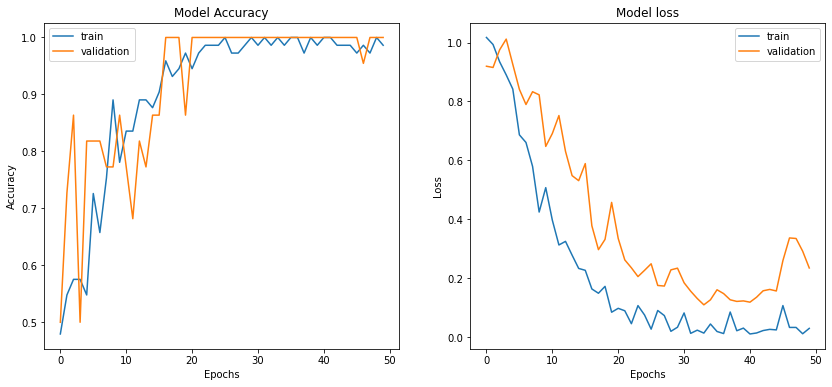

In [14]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()

plt.subplot(1,2,2)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.plot(history.history['loss'], label="train")
plt.plot(history.history['val_loss'], label="validation")
plt.legend()

In [15]:
#model.save("model_122k")

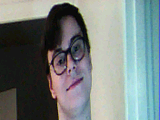

In [16]:
keras.utils.array_to_img(validation_data[0])

In [17]:
img_axis = validation_data[0][None,:,:,:]
img_axis.shape

(1, 120, 160, 3)

In [18]:
pred = model.predict(img_axis)
with np.printoptions(precision=2, suppress=True):
    print(pred)
le.inverse_transform([np.argmax(pred)])

[[0.13 0.09 0.79]]


array(['Simon'], dtype='<U6')

In [19]:
# This model should not be used either, kept for reference
model_45k = keras.models.Sequential([
    keras.layers.Input(shape=train_data.shape[1:]),
    keras.layers.MaxPool2D((2,2), input_shape=train_data.shape[1:]),
    keras.layers.Dropout(0.5),
    keras.layers.Conv2D(16, (3,3), activation="relu"),
    keras.layers.MaxPool2D((2,2)),
    keras.layers.Conv2D(32, (3,3), activation="relu"),
    keras.layers.MaxPool2D((2,2)),
    keras.layers.Conv2D(32, (3,3), activation="relu"),
    keras.layers.MaxPool2D((2,2)),
    keras.layers.Conv2D(32, (3,3), activation="relu"),
    keras.layers.MaxPool2D((2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(classes, activation="softmax")
    ])

model_45k.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
#model_45k.summary()

In [20]:
history_45k = model_45k.fit(train_data, train_labels, validation_data=(validation_data, validation_labels), batch_size=32, epochs=50)#, callbacks=[callback])

Epoch 1/50
3/3 [==============================] - 1s 85ms/step - loss: 1.1184 - accuracy: 0.3151 - val_loss: 1.0209 - val_accuracy: 0.5909
Epoch 2/50
3/3 [==============================] - 0s 35ms/step - loss: 1.0200 - accuracy: 0.4247 - val_loss: 0.9715 - val_accuracy: 0.9091
Epoch 3/50
3/3 [==============================] - 0s 34ms/step - loss: 0.9893 - accuracy: 0.4384 - val_loss: 0.9587 - val_accuracy: 0.8636
Epoch 4/50
3/3 [==============================] - 0s 35ms/step - loss: 0.9719 - accuracy: 0.5479 - val_loss: 0.9463 - val_accuracy: 0.9091
Epoch 5/50
3/3 [==============================] - 0s 41ms/step - loss: 0.9407 - accuracy: 0.6575 - val_loss: 0.9266 - val_accuracy: 0.6818
Epoch 6/50
3/3 [==============================] - 0s 40ms/step - loss: 0.9297 - accuracy: 0.6712 - val_loss: 0.8871 - val_accuracy: 0.7727
Epoch 7/50
3/3 [==============================] - 0s 37ms/step - loss: 0.8798 - accuracy: 0.6575 - val_loss: 0.8454 - val_accuracy: 0.9091
Epoch 8/50
3/3 [===========

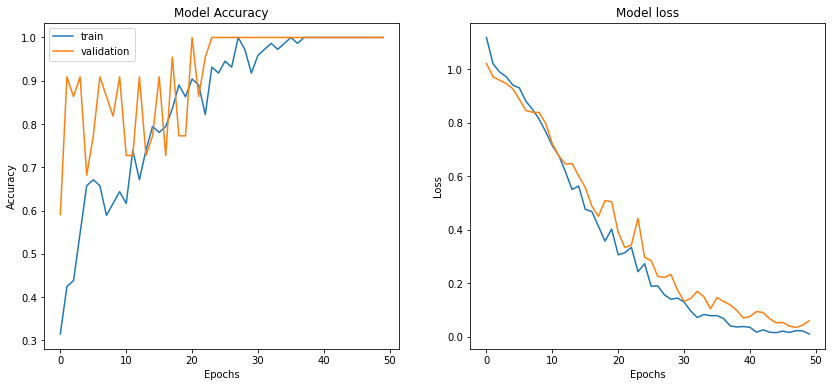

In [21]:
plt.figure(figsize=(14,6))
plt.subplot(1,2,1)
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.plot(history_45k.history['accuracy'], label='train')
plt.plot(history_45k.history['val_accuracy'], label='validation')
plt.legend()

plt.subplot(1,2,2)
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.plot(history_45k.history['loss'], label="train")
plt.plot(history_45k.history['val_loss'], label="validation")

In [ ]:
#model_45k.save("model_45k")